---

In [2]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random

---

In [3]:
import numpy as np

def project_onto_C1(p, mu):
    """Project p onto C1: Marginal matching for mu."""
    return p * (mu / (p.sum(axis=1) + 1e-8))

def project_onto_C2(p, nu):
    """Project p onto C2: Marginal matching for nu."""
    return p * (nu / (p.sum(axis=0) + 1e-8))

def project_onto_martingale_constraint(p, xi, yj, mu):
    """Project p onto C2+l: Martingale constraint."""
    expected_y_per_x = np.dot(p, yj) / (mu + 1e-8)
    adjustment_factors = xi / expected_y_per_x
    adjustment_factors = np.where(np.isnan(adjustment_factors), 1, adjustment_factors)
    p_adjusted = p * adjustment_factors[:, None]
    return p_adjusted

def bregman_projection(mu, nu, xi, yj, C, max_iter=100):
    m, n = C.shape
    p = np.exp(-C)  # Initial guess
    p /= np.sum(p)  # Normalize
    for _ in range(max_iter):
        p = project_onto_C1(p, mu)
        p = project_onto_C2(p, nu)
        p = project_onto_martingale_constraint(p, xi, yj, mu)
        # Normalize p again to ensure it's a probability distribution
        p /= np.sum(p)
       
    return p

# Define the support and cost matrix for uniform distributions
def uniform_support(a, b, n):
    return np.linspace(a, b, n)

def cost_matrix(xi, yj):
    return (xi[:, None]*yj)

# Define the parameters for the uniform distributions
mu_a, mu_b = -1, 1
nu_a, nu_b = -2, 2
n = 100  # Number of support points for each distribution

# Generate the support points for mu and nu
xi = uniform_support(mu_a, mu_b, n)
yj = uniform_support(nu_a, nu_b, n)

# Generate the cost matrix
C = cost_matrix(xi, yj)

# Generate the uniform distributions mu and nu
mu = np.ones(n) / n
nu = np.ones(n) / n

# Perform the Bregman projection
p_star = bregman_projection(mu, nu, xi, yj, C)

print("Optimal transport plan p*:")
print(p_star)

Optimal transport plan p*:
[[4.89317713e-04 4.76513384e-04 4.63787617e-04 ... 2.14951910e-07
  1.87891985e-07 1.64147806e-07]
 [4.70931961e-04 4.59358030e-04 4.47820879e-04 ... 2.42370403e-07
  2.12204951e-07 1.85691198e-07]
 [4.52977497e-04 4.42566721e-04 4.32156211e-04 ... 2.73129804e-07
  2.39526738e-07 2.09941737e-07]
 ...
 [2.09941737e-07 2.39526738e-07 2.73129804e-07 ... 4.32156211e-04
  4.42566721e-04 4.52977497e-04]
 [1.85691198e-07 2.12204951e-07 2.42370403e-07 ... 4.47820879e-04
  4.59358030e-04 4.70931961e-04]
 [1.64147806e-07 1.87891985e-07 2.14951910e-07 ... 4.63787617e-04
  4.76513384e-04 4.89317713e-04]]


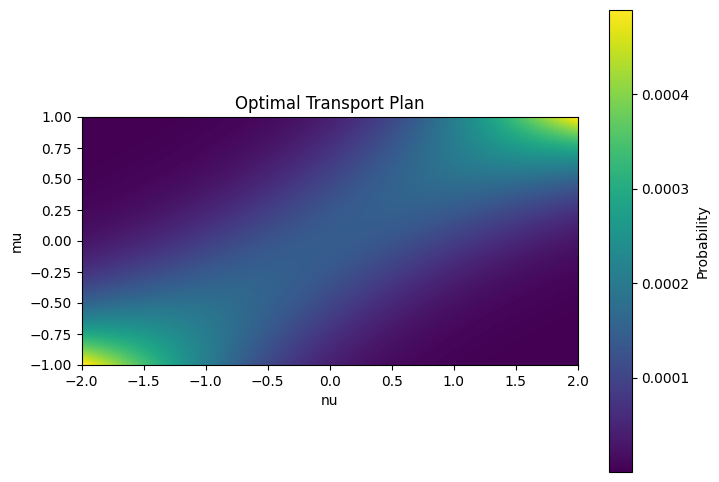

In [4]:
# Plot the optimal transport plan
plt.figure(figsize=(8, 6))
plt.imshow(p_star, cmap='viridis', origin='lower', extent=[nu_a, nu_b, mu_a, mu_b])
plt.colorbar(label='Probability')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('Optimal Transport Plan')
plt.show()

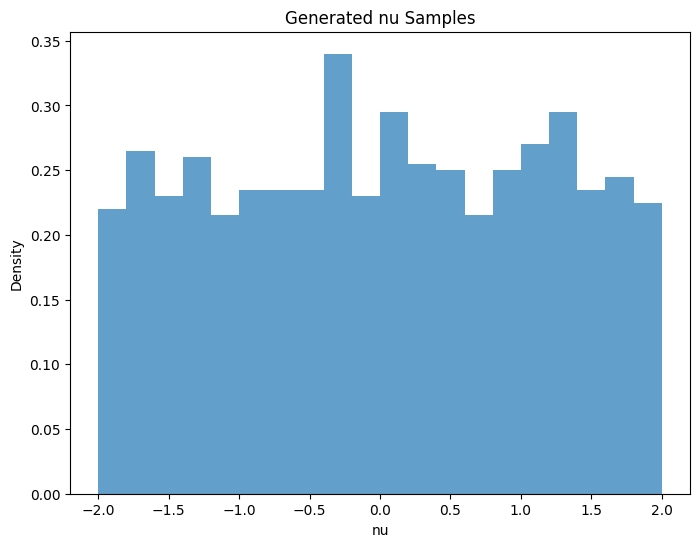

In [5]:
# Generate new nu samples using the optimal transport plan
num_samples = 1000
mu_samples = np.random.choice(xi, size=num_samples, p=mu)
nu_samples = []
for x in mu_samples:
    idx = np.where(xi == x)[0][0]
    p_row = p_star[idx] / np.sum(p_star[idx])  # Normalize the row probabilities
    nu_samples.append(np.random.choice(yj, p=p_row))
nu_samples = np.array(nu_samples)

# Plot the generated nu samples
plt.figure(figsize=(8, 6))
plt.hist(nu_samples, bins=20, density=True, alpha=0.7)
plt.xlabel('nu')
plt.ylabel('Density')
plt.title('Generated nu Samples')
plt.show()

In [7]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(nu_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
expected_cost = np.mean(cost_matrix(mu_samples, nu_samples))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(cost_matrix(mu_samples, nu_samples))
rhs = np.sqrt(np.mean((mu_samples - nu_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(nu_samples - mu_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): True
Expected cost E[c(X, Y)]: 1.6645272229364354
Inequality holds: False
Martingale difference: 0.006888888888888975
Martingale difference is close to 0: True
